## I propose the question "Does a student's parental education and ethnic background have any basis on how a student will perform on a Math/Reading/Writing Test

In [318]:
import numpy as np
import pandas as pd
pd.set_option('max_columns',100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
import pickle

In [353]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score

## How should this problem be framed, I think by first doing some exploratory analysis will help lead to that decision

In [320]:
data = pd.read_csv('StudentsPerformance.csv')
df = data.copy()
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### From the heatmap we can see that there isn't enough numerical data to make a clear hypothesis and there needs to either be some mapping of the catergorical types or grouping by scores of the numerical types to be able to use a classifier or unsupervised learning

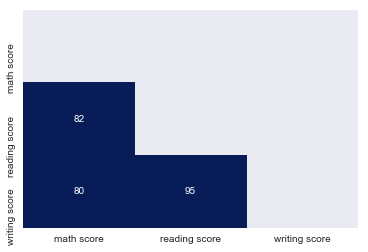

In [321]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr*100,vmin=-1,vmax=1,annot=True, fmt='.0f',cmap="YlGnBu",mask=mask,cbar=False)
plt.show()

In [322]:
def count_plot(df):
    category = list(df.select_dtypes(include='object'))
    for c in category:
        sns.countplot(x=c,data=df)
        plt.show()
# count_plot(df)

### Let's first trying changing the numerical columns to catergorical types ranging from the standard school grading system of A-F

In [323]:
def grading_scale(x):
    if x >= 90:
        x = 'A'
    elif x <= 89 & x >= 80:
        x = 'B'
    elif x <= 79 & x >= 70:
        x = 'C'
    elif x <= 69 & x >= 60:
        x = 'D'
    elif x <= 59:
        x  = 'F'
    else:
        x = 'Missing'
    return x

In [324]:
# Categorical Scoring
df['Math_score'] = df['math score'].apply(grading_scale)
df['Reading_score'] = df['reading score'].apply(grading_scale)
df['Writing_score'] = df['writing score'].apply(grading_scale)
df.drop(['math score','reading score','writing score'],axis=1,inplace=True)
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,Math_score,Reading_score,Writing_score
0,female,group B,bachelor's degree,standard,none,C,C,C
1,female,group C,some college,standard,completed,D,A,B
2,female,group B,master's degree,standard,none,A,A,A
3,male,group A,associate's degree,free/reduced,none,F,F,F
4,male,group C,some college,standard,none,C,C,C


## Double check there are no missing values or incorrect types


In [325]:
print('NULL VALUES IN DATAFRAME\n--------------------------------------\n{}\n'.format(df.isnull().sum()))
print('--------------------------------------\n')
print('DATA TYPES\n--------------------------------------\n{}'.format(df.dtypes))

NULL VALUES IN DATAFRAME
--------------------------------------
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
Math_score                     0
Reading_score                  0
Writing_score                  0
dtype: int64

--------------------------------------

DATA TYPES
--------------------------------------
gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
Math_score                     object
Reading_score                  object
Writing_score                  object
dtype: object


### I'm using a multilabel classification for my first testing series

In [326]:
def mulit_labeling(df):
    # Using race/ethnicity and parental level of education for the multilabel classification 
    multi_label = np.c_[df[['race/ethnicity','parental level of education']]]
    X = df.drop(df[['race/ethnicity','parental level of education']],axis=1)
    y = multi_label

    # Splitting data for test set
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=123)
    # print(len(X_train),len(X_test),len(y_train),len(y_test))
    # print(X_train[:5])
    # print(X_test[:5])
    return X_train,X_test,y_train,y_test

In [327]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,Math_score,Reading_score,Writing_score
0,female,group B,bachelor's degree,standard,none,C,C,C
1,female,group C,some college,standard,completed,D,A,B
2,female,group B,master's degree,standard,none,A,A,A
3,male,group A,associate's degree,free/reduced,none,F,F,F
4,male,group C,some college,standard,none,C,C,C


In [328]:
enc = LabelEncoder()
category = list(df.select_dtypes(include='object'))
for c in category:
    df[c] = enc.fit_transform(df[c])

In [329]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,Math_score,Reading_score,Writing_score
0,0,1,1,1,1,2,2,2
1,0,2,4,1,0,3,0,1
2,0,1,3,1,1,0,0,0
3,1,0,0,0,1,4,4,4
4,1,2,4,1,1,2,2,2


### Do we care that the weight scale for the grades and students seems to be oppose of what I believe it should be? Let's find out at what accuracy the model will produce with Labelencoding this way.

In [330]:
X_train,X_test,y_train,y_test = mulit_labeling(df)

In [331]:
pipelines = {'km': make_pipeline(StandardScaler(),KMeans(random_state=123))
            }

km_hyperparameters = {
                      'kmeans__n_clusters':[2,3,4],
                      'kmeans__max_iter':[200,300,400]
                      }

hyperparameters = {
                   'km':km_hyperparameters,
                   }

In [332]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

km has been fitted.


In [333]:
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

km has been fitted.


In [334]:
for name, model in fitted_models.items():
    print( name, model.best_score_ )

km -322.97623900444387
